In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
#read raw data
df = pd.read_csv('Book1.csv')

if df.isnull().values.any():
    print ('missing values!')
    #raise ValueError
else:
    print('pass')

removed_mol = ["ASD007", "ASD012", "ASD019", "ASD021", "D372-0163"]
df = df[~df['MolID'].isin(removed_mol)]

df

missing values!


,MolID,wt_A2_slope,pore_A2_slope,pd3_A2_slope,pd3pore_A2_slope,A2_pore/wt,A2_pd3/wt,A2_pd3-pore/wt,A2_10,A2_20,...,PMI3,RadiusOfGyration,SpherocityIndex,avg_asphericity,avg_acylindricity,avg_kappa2,avg_rg,avg_largest_principal_rg,avg_middle_principal_rg,avg_smallest_principal_rg
0,1500272,0.874,1.201,1.003,1.589,1.374142,1.147597,1.818078,13.25,29.46,...,8960.40,4.71,0.26,0.377154,0.212826,0.287922,0.526401,0.505270,0.457168,0.299362
1,1501007,1.224,2.024,2.130,2.240,1.653595,1.740196,1.830065,14.31,23.01,...,5322.33,4.43,0.13,0.310194,0.123611,0.349557,0.411174,0.391925,0.369452,0.216417
2,1501150,2.652,3.351,2.902,3.416,1.263575,1.094268,1.288084,40.09,79.97,...,4454.32,3.82,0.13,0.307322,0.156884,0.302154,0.421545,0.403439,0.370261,0.235260
3,1503100,10.150,10.846,8.314,9.200,1.068571,0.819113,0.906404,124.53,232.97,...,6975.32,4.50,0.21,0.402013,0.129149,0.435131,0.498724,0.478465,0.459285,0.236546
4,1503243,7.582,10.841,10.928,13.618,1.429834,1.441308,1.796096,106.38,200.59,...,6455.60,4.67,0.11,0.365638,0.124397,0.441792,0.454138,0.437384,0.416621,0.212002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,ST074710,3.312,3.862,3.265,3.836,1.166063,0.985809,1.158213,62.75,87.03,...,7862.80,4.82,0.12,0.408958,0.115699,0.485836,0.491210,0.473402,0.457345,0.221208
82,ST074716,3.040,4.275,4.721,5.291,1.406250,1.552961,1.740461,61.47,87.52,...,9674.41,5.13,0.12,0.416993,0.196128,0.419995,0.525883,0.512063,0.472004,0.259160
83,D724-0097,9.600,12.312,8.999,11.838,1.282500,0.937396,1.233125,217.04,397.61,...,3445.24,3.45,0.21,0.209107,0.229186,0.161560,0.399372,0.383872,0.307732,0.277063
84,ciprofloxacin,3.232,4.005,2.535,3.767,1.239171,0.784344,1.165532,1.10,101.01,...,4263.15,3.74,0.09,0.301786,0.172059,0.348878,0.400354,0.389923,0.349846,0.214736


## Tuned hyper parameters


### 31 Given features (RDkit + MD), after hand selection and feature clustering


In [2]:
# # ------ slopes, threshold = 3rd quatile ------
# #---wt_A2_slope---
# RF_tuned_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 640}
# #Best score: 0.8552631578947368
# #---pore_A2_slope---
# RF_tuned_params = {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 160}
# #Best score: 0.8868421052631579
# #---pd3_A2_slope---
# RF_tuned_params = {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 160}
# #Best score: 0.8531578947368421
# #---pd3pore_A2_slope---
# RF_tuned_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 160}
# #Best score: 0.8421052631578947

# # ------- ratios, threshold = 1.2 -------
# #---A2_pore/wt---
# RF_tuned_params = {'max_depth': 5, 'max_features': 30, 'min_samples_leaf': 4, 'n_estimators': 640}
# #Best score: 0.74
# #---A2_pd3/wt---
# RF_tuned_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1280}
# #Best score: 0.8928571428571429
# #---A2_pd3-pore/wt---
# RF_tuned_params = {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 160}
# #Best score: 0.7382352941176471

# # ------ amplitudes, threshold = 3rd quatile ------
# #---A2_10---
# RF_tuned_params = {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 160}
# #Best score: 0.8236842105263158
# #---A2_20---
# RF_tuned_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 640}
# #Best score: 0.8347368421052632
# #---A2_40---
# RF_tuned_params = {'max_depth': None, 'max_features': 20, 'min_samples_leaf': 1, 'n_estimators': 320}
# #Best score: 0.8031578947368422
# #---A2_80---
# RF_tuned_params = {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 320}
# #Best score: 0.8136842105263158

RF_tuned_params_list = [{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 640},
{'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 160},
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 160},
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 160},
{'max_depth': 5, 'max_features': 30, 'min_samples_leaf': 4, 'n_estimators': 640},
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1280},
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 160},
{'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 160},
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 640},
{'max_depth': None, 'max_features': 20, 'min_samples_leaf': 1, 'n_estimators': 320},
{'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 320}]

## functions

In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import (recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, 
                             auc,roc_auc_score,roc_curve, precision_recall_curve,classification_report)

from sklearn.ensemble import RandomForestClassifier

def data_split(X, Y, test_size, random_state=0):
    if not (type(X) is np.ndarray):
        X = X.to_numpy()
    if not (type(Y) is np.ndarray):
        Y = Y.to_numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = test_size, random_state=random_state)

    return X_train, X_test, Y_train, Y_test

#K-fold validation function will take six arguments: 
#1. model, 2. train set, 3.test set, 4.# of fold, 5.shuffle boolean, 6.random_state.
def kf_cv(clf, X, y, FigureTitel=None, folds=5, shuf=True, random_state=0):
    cv = KFold(n_splits=folds, random_state=random_state, shuffle=shuf)
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])
    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    i = 0
    for train_index, val_index in cv.split(X):
        #turn on the below code will print train_index/test_index and may help understand the details and debug.
        #print("Train Index: ", type(train_index), "\n")
        #print("Test Index: ", test_index)
        
        X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
        #if sampling method is used, use this to avoid warnings: clf.fit(X_train.values, y_train.values.ravel())
        clf.fit(X_train, y_train.ravel())
        
        pred_val = clf.predict(X_val)
        pred_val_probs = clf.predict_proba(X_val)
        #print(pred_test_probs)
        fpr, tpr, _ = roc_curve(y_val,pred_val_probs[:,1]) # use pred_test_probs instead of pred_test
        
        f1.append(f1_score(y_val,pred_val))
        prec.append(precision_score(y_val,pred_val))
        recall.append(recall_score(y_val,pred_val))
        acc.append(accuracy_score(y_val,pred_val))
        ROC_AUC.append(roc_auc_score(y_val, pred_val_probs[:,1]))       
        conf.append(confusion_matrix(y_val,pred_val))

        plt.plot(fpr, tpr, label=str(i))
        i += 1 # plot ROC curve
    
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.title(FigureTitel)
    plt.show()
    #return a dataframe consisting five metrics and confusion matrix.
    return pd.DataFrame(zip(f1,prec,recall,acc,ROC_AUC,conf), columns = metric_cols)

## Cross-validation, test, and ROC curve

### wt_A2_slope ###


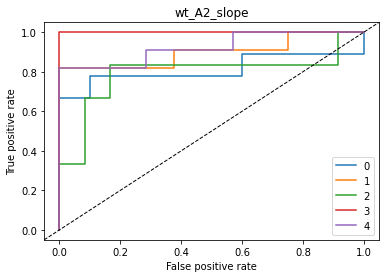

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.83       0.79    0.87      0.83
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.777778   0.777778  0.777778  0.789474  0.811111   [[8, 2], [2, 7]]
1  0.818182   0.818182  0.818182  0.789474  0.897727   [[6, 2], [2, 9]]
2  0.769231   0.714286  0.833333  0.833333  0.791667  [[10, 2], [1, 5]]
3  0.900000   0.818182  1.000000  0.888889  1.000000   [[7, 2], [0, 9]]
4  0.869565   0.833333  0.909091  0.833333  0.922078  [[5, 2], [1, 10]]
-----      Test      -----
      F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.67        1.0     0.5      0.94      0.9  [[15, 0], [1, 1]] 

### pore_A2_slope ###


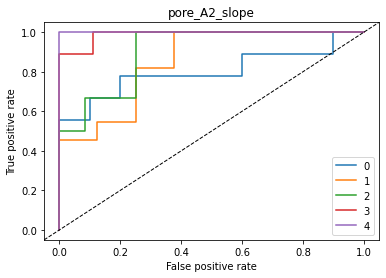

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.85       0.82     0.9      0.85
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.777778   0.777778  0.777778  0.789474  0.800000   [[8, 2], [2, 7]]
1  0.818182   0.818182  0.818182  0.789474  0.852273   [[6, 2], [2, 9]]
2  0.750000   0.600000  1.000000  0.777778  0.902778   [[8, 4], [0, 6]]
3  0.947368   0.900000  1.000000  0.944444  0.987654   [[8, 1], [0, 9]]
4  0.952381   1.000000  0.909091  0.944444  1.000000  [[7, 0], [1, 10]]
-----      Test      -----
     F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.5        0.5     0.5      0.88      0.9  [[14, 1], [1, 1]] 

### pd3_A2_slope ###


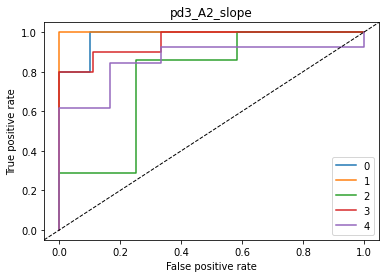

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.87       0.83    0.92      0.86
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.952381   0.909091  1.000000  0.950000  0.980000  [[9, 1], [0, 10]]
1  0.941176   0.888889  1.000000  0.947368  1.000000  [[10, 1], [0, 8]]
2  0.705882   0.600000  0.857143  0.736842  0.773810   [[8, 4], [1, 6]]
3  0.857143   0.818182  0.900000  0.842105  0.955556   [[7, 2], [1, 9]]
4  0.880000   0.916667  0.846154  0.842105  0.858974  [[5, 1], [2, 11]]
-----      Test      -----
      F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.33        0.5    0.25      0.75     0.62  [[11, 1], [3, 1]] 

### pd3pore_A2_slope ###


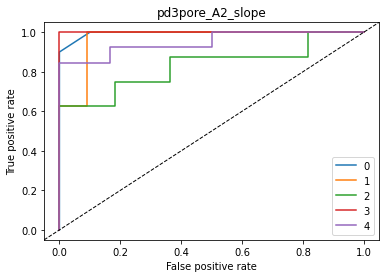

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.84        0.8    0.89      0.84
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.952381   0.909091  1.000000  0.950000  0.995000  [[9, 1], [0, 10]]
1  0.842105   0.727273  1.000000  0.842105  0.965909   [[8, 3], [0, 8]]
2  0.666667   0.714286  0.625000  0.736842  0.829545   [[9, 2], [3, 5]]
3  0.857143   0.750000  1.000000  0.842105  1.000000   [[7, 3], [0, 9]]
4  0.880000   0.916667  0.846154  0.842105  0.948718  [[5, 1], [2, 11]]
-----      Test      -----
     F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.0        0.0     0.0      0.75     0.54  [[12, 0], [4, 0]] 

### A2_pore/wt ###
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


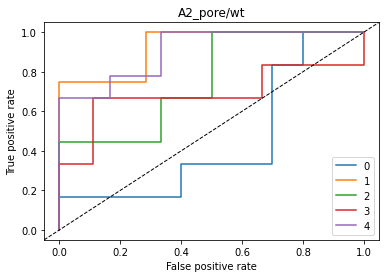

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.62       0.62    0.63      0.66
         F1  precision    recall  accuracy   ROC_AUC  confusion_matrix
0  0.181818   0.200000  0.166667  0.437500  0.450000  [[6, 4], [5, 1]]
1  0.823529   0.777778  0.875000  0.800000  0.928571  [[5, 2], [1, 7]]
2  0.705882   0.750000  0.666667  0.666667  0.759259  [[4, 2], [3, 6]]
3  0.571429   0.500000  0.666667  0.600000  0.685185  [[5, 4], [2, 4]]
4  0.823529   0.875000  0.777778  0.800000  0.907407  [[5, 1], [2, 7]]
-----      Test      -----
      F1  precision  recall  accuracy  ROC_AUC  confusion_matrix
RF  0.43        0.6    0.33      0.53     0.61  [[6, 2], [6, 3]] 

### A2_pd3/wt ###


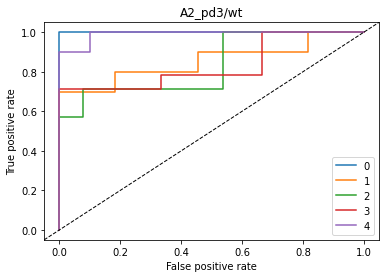

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.83       0.82    0.85      0.83
         F1  precision    recall  accuracy   ROC_AUC    confusion_matrix
0  0.952381   0.909091  1.000000  0.952381  1.000000  [[10, 1], [0, 10]]
1  0.761905   0.727273  0.800000  0.761905  0.854545    [[8, 3], [2, 8]]
2  0.714286   0.714286  0.714286  0.800000  0.835165   [[11, 2], [2, 5]]
3  0.800000   0.909091  0.714286  0.750000  0.833333   [[5, 1], [4, 10]]
4  0.909091   0.833333  1.000000  0.900000  0.990000   [[8, 2], [0, 10]]
-----      Test      -----
     F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.0        0.0     0.0      0.62     0.33  [[10, 5], [1, 0]] 

### A2_pd3-pore/wt ###


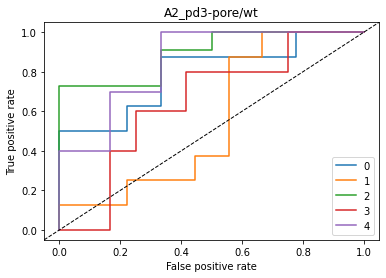

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.62       0.66    0.61      0.64
         F1  precision    recall  accuracy   ROC_AUC  confusion_matrix
0  0.571429   0.666667  0.500000  0.647059  0.791667  [[7, 2], [4, 4]]
1  0.555556   0.500000  0.625000  0.529412  0.555556  [[4, 5], [3, 5]]
2  0.777778   1.000000  0.636364  0.764706  0.893939  [[6, 0], [4, 7]]
3  0.461538   0.375000  0.600000  0.588235  0.650000  [[7, 5], [2, 3]]
4  0.736842   0.777778  0.700000  0.687500  0.850000  [[4, 2], [3, 7]]
-----      Test      -----
      F1  precision  recall  accuracy  ROC_AUC  confusion_matrix
RF  0.53       0.45    0.62      0.44      0.5  [[2, 6], [3, 5]] 

### A2_10 ###


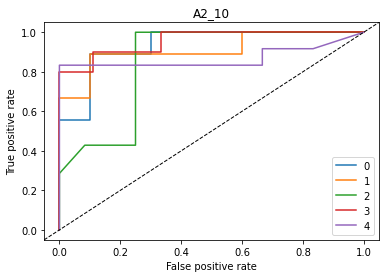

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.82       0.81    0.85      0.82
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.823529   0.875000  0.777778  0.842105  0.933333   [[9, 1], [2, 7]]
1  0.761905   0.666667  0.888889  0.736842  0.911111   [[6, 4], [1, 8]]
2  0.750000   0.666667  0.857143  0.789474  0.851190   [[9, 3], [1, 6]]
3  0.857143   0.818182  0.900000  0.842105  0.955556   [[7, 2], [1, 9]]
4  0.909091   1.000000  0.833333  0.888889  0.868056  [[6, 0], [2, 10]]
-----      Test      -----
      F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.29       0.25    0.33      0.69     0.56  [[10, 3], [2, 1]] 

### A2_20 ###


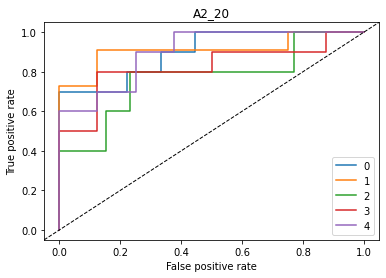

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.79       0.78    0.84      0.79
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.823529   1.000000  0.700000  0.842105  0.900000   [[9, 0], [3, 7]]
1  0.869565   0.833333  0.909091  0.842105  0.909091  [[6, 2], [1, 10]]
2  0.533333   0.400000  0.800000  0.611111  0.769231   [[7, 6], [1, 4]]
3  0.842105   0.888889  0.800000  0.833333  0.825000   [[7, 1], [2, 8]]
4  0.869565   0.769231  1.000000  0.833333  0.900000  [[5, 3], [0, 10]]
-----      Test      -----
     F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.4       0.33     0.5      0.82      0.9  [[13, 2], [1, 1]] 

### A2_40 ###


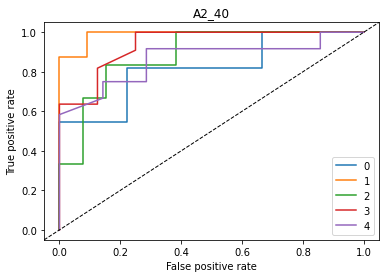

----- Cross Validation -----
     F1  precision  recall  accuracy
RF  0.8       0.77    0.86       0.8
         F1  precision    recall  accuracy   ROC_AUC   confusion_matrix
0  0.631579   0.750000  0.545455  0.650000  0.818182   [[7, 2], [5, 6]]
1  0.941176   0.888889  1.000000  0.947368  0.988636  [[10, 1], [0, 8]]
2  0.714286   0.625000  0.833333  0.789474  0.884615  [[10, 3], [1, 5]]
3  0.846154   0.733333  1.000000  0.789474  0.937500  [[4, 4], [0, 11]]
4  0.880000   0.846154  0.916667  0.842105  0.863095  [[5, 2], [1, 11]]
-----      Test      -----
      F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.25       0.25    0.25      0.65     0.57  [[10, 3], [3, 1]] 

### A2_80 ###


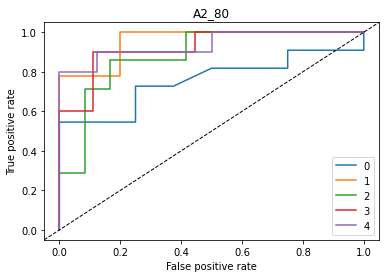

----- Cross Validation -----
      F1  precision  recall  accuracy
RF  0.81        0.8    0.81      0.81
         F1  precision    recall  accuracy   ROC_AUC  confusion_matrix
0  0.700000   0.777778  0.636364  0.684211  0.755682  [[6, 2], [4, 7]]
1  0.777778   0.777778  0.777778  0.789474  0.955556  [[8, 2], [2, 7]]
2  0.750000   0.666667  0.857143  0.789474  0.880952  [[9, 3], [1, 6]]
3  0.900000   0.900000  0.900000  0.894737  0.922222  [[8, 1], [1, 9]]
4  0.900000   0.900000  0.900000  0.888889  0.937500  [[7, 1], [1, 9]]
-----      Test      -----
     F1  precision  recall  accuracy  ROC_AUC   confusion_matrix
RF  0.4        0.5    0.33      0.82     0.86  [[13, 1], [2, 1]] 



In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

Ycolumns = ["wt_A2_slope", "pore_A2_slope", "pd3_A2_slope", "pd3pore_A2_slope", "A2_pore/wt", "A2_pd3/wt", "A2_pd3-pore/wt", "A2_10", "A2_20", "A2_40", "A2_80"]

descriptors = ['LabuteASA', 'NPR2', 'BalabanJ', 'MaxAbsEStateIndex', 'PMI3', 'MaxPartialCharge', 'MinEStateIndex', 'EState_VSA11', 'FractionCSP3', 'EState_VSA1', 'FpDensityMorgan2', 'avg_largest_principal_rg', 'avg_acylindricity', 'NPR1', 'NumAromaticHeterocycles', 'MinAbsEStateIndex', 'Kappa2', 'NumAliphaticHeterocycles', 'Chi3n', 'NumHAcceptors', 'EState_VSA3', 'NumHeteroatoms', 'NumHDonors', 'HallKierAlpha', 'NumAromaticCarbocycles', 'EState_VSA5', 'NumRotatableBonds', 'PMI1', 'EState_VSA7', 'EState_VSA2', 'EState_VSA9']

feature_importance = {}
feature_importance["Features"] = descriptors

for column, RF_tuned_params in zip(Ycolumns, RF_tuned_params_list): # use different Y in every iteration
    print(f"### {column} ###")
    ### specify X and Y ###
    df_no_nan = df.dropna(subset=[column]) # drop row if NaN in Y
    Y = df_no_nan[column]

    if column in ["A2_pore/wt", "A2_pd3/wt", "A2_pd3-pore/wt"]:
        threshold = 1.2 # slope ratios
    else:
        threshold = np.quantile(Y, 0.75) # amplitude and slope
    
    Yb = (Y > threshold).astype(int) # binary classification split by threshold
    X_raw = df_no_nan.iloc[:,12:]

    ### scale X ###
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
    
    X_given = X_scaled[descriptors]

    ### Train-Test split ###
    X_train, X_test, Y_train, Y_test = data_split(X_given, Yb, 0.2)


    #re-sampling
    X_resampled, Y_resampled = SMOTE().fit_resample(X_train, Y_train)

    ### Cross-Validation ###
    RF = RandomForestClassifier(random_state=0).set_params(**RF_tuned_params)
    #create dictionary to store k-fold CV results
    cv_score_dict = {}
    #create a dataframe to store the mean and standard error of the mean (SEM) from k-fold CV
    cv_score_mean = pd.DataFrame()
    cv_score_sem = pd.DataFrame()

    cv_score_dict['RF'] = kf_cv(RF,X_resampled,Y_resampled,FigureTitel=column, folds=5, shuf=True)
    cv_score_mean['RF'] = cv_score_dict['RF'].mean()[:-1]
    cv_score_sem['RF'] = cv_score_dict['RF'].sem()
        
    cv_score_mean = cv_score_mean.transpose().astype(float).round(2)
    cv_score_sem = cv_score_sem.transpose().round(2)

    # check mean performance of each model.
    print("----- Cross Validation -----")
    print(cv_score_mean)
    print(cv_score_dict['RF'])

    ### Test ###
    test_set_result = pd.DataFrame()
    f1,prec,recall,acc,ROC_AUC,conf = ([],[],[],[],[],[])

    #evaluate the performance of the different classifiers
    RF.fit(X_resampled, Y_resampled) # fit again will flush

    Y_pred = RF.predict(X_test)
    pred_test_probs = RF.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(Y_test,Y_pred)

    f1.append(f1_score(Y_test,Y_pred))
    prec.append(precision_score(Y_test,Y_pred))
    recall.append(recall_score(Y_test,Y_pred))
    acc.append(accuracy_score(Y_test,Y_pred))
    ROC_AUC.append(roc_auc_score(Y_test, pred_test_probs[:,1]))       
    conf.append(confusion_matrix(Y_test,Y_pred))
        
    test_set_scores = zip(f1,prec,recall,acc,ROC_AUC,conf)   

    test_set_result = pd.DataFrame(test_set_scores,
                                columns=['F1','precision','recall',
                                            'accuracy','ROC_AUC','confusion_matrix'], 
                                index = ['RF'])
    print("-----      Test      -----")
    print(test_set_result.round(2),"\n")

    ### feature importance ###
    feature_importance[column] = RF.feature_importances_

In [5]:
# feature importance
print(pd.DataFrame(feature_importance))

                    Features  wt_A2_slope  pore_A2_slope  pd3_A2_slope  \
0                  LabuteASA     0.020504       0.024726      0.025738   
1                       NPR2     0.048058       0.034176      0.058313   
2                   BalabanJ     0.028676       0.013260      0.032082   
3          MaxAbsEStateIndex     0.023410       0.034307      0.018173   
4                       PMI3     0.034428       0.022636      0.033897   
5           MaxPartialCharge     0.017440       0.015379      0.025238   
6             MinEStateIndex     0.032502       0.035969      0.031877   
7               EState_VSA11     0.001085       0.002039      0.001839   
8               FractionCSP3     0.038735       0.020320      0.031755   
9                EState_VSA1     0.019232       0.016455      0.011594   
10          FpDensityMorgan2     0.031543       0.027309      0.030196   
11  avg_largest_principal_rg     0.019013       0.014805      0.007586   
12         avg_acylindricity     0.024

In [6]:
#descriptors = ['FpDensityMorgan2', 'LabuteASA', 'MaxAbsEStateIndex', 'TPSA', 'EState_VSA7', 'Asphericity', 'Chi3v', 'MaxPartialCharge', 'PMI2', 'MaxAbsPartialCharge', 'NPR1', 'EState_VSA4', 'MinPartialCharge', 'Kappa3', 'MolLogP', 'NumHAcceptors', 'EState_VSA1', 'FractionCSP3', 'EState_VSA11', 'EState_VSA5', 'NumAliphaticCarbocycles', 'EState_VSA2', 'EState_VSA6', 'NumAromaticHeterocycles', 'EState_VSA9', 'BalabanJ', 'HallKierAlpha', 'EState_VSA3', 'MinAbsEStateIndex', 'EState_VSA8', 'InertialShapeFactor', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles'] # Valentin
#descriptors = ['NumAliphaticCarbocycles', 'Chi0n', 'NumHDonors', 'FpDensityMorgan2', 'MaxAbsEStateIndex', 'MaxPartialCharge', 'EState_VSA11', 'NPR1', 'EState_VSA2', 'PMI3', 'PMI1', 'EState_VSA8', 'MinEStateIndex', 'NPR2', 'NumHeteroatoms', 'EState_VSA1', 'Kappa3', 'EState_VSA3', 'MolLogP'] # 2D Rdkit
#descriptors = ['LabuteASA', 'NPR2', 'BalabanJ', 'MaxAbsEStateIndex', 'PMI3', 'MaxPartialCharge', 'MinEStateIndex', 'EState_VSA11', 'FractionCSP3', 'EState_VSA1', 'FpDensityMorgan2', 'avg_largest_principal_rg', 'avg_acylindricity', 'NPR1', 'NumAromaticHeterocycles', 'MinAbsEStateIndex', 'Kappa2', 'NumAliphaticHeterocycles', 'Chi3n', 'NumHAcceptors', 'EState_VSA3', 'NumHeteroatoms', 'NumHDonors', 'HallKierAlpha', 'NumAromaticCarbocycles', 'EState_VSA5', 'NumRotatableBonds', 'PMI1', 'EState_VSA7', 'EState_VSA2', 'EState_VSA9'] # 2D Rdkit + MD

## Probability density plot

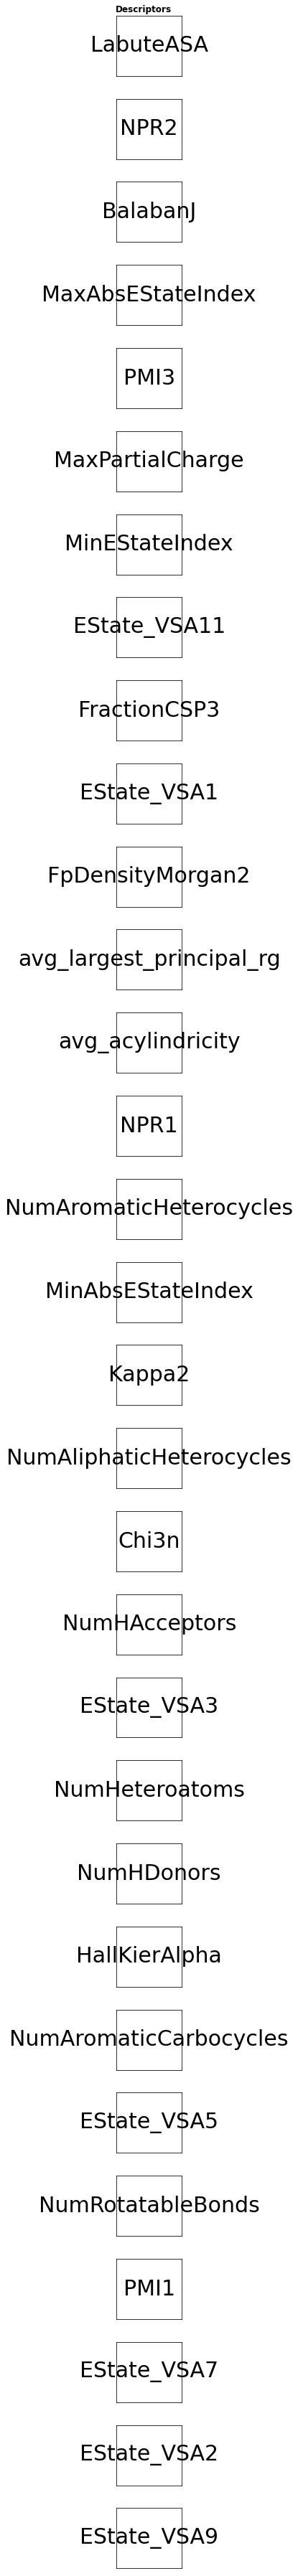

'\nfor column in Ycolumns: # use different Y in every iteration\n    print(column)\n    #matrix figure\n    fig, axs = plt.subplots(nrows=31, ncols=1, figsize=(2,50))\n    plt.tight_layout()\n    ### specify X and Y ###\n    df_no_nan = df.dropna(subset=[column]) # drop row if NaN in Y\n    Y = df_no_nan[column]\n    \n    if column in ["A2_pore/wt", "A2_pd3/wt", "A2_pd3-pore/wt"]:\n        threshold = 1.2 # slope ratios\n    else:\n        threshold = np.quantile(Y, 0.75) # amplitude and slope\n    \n    Yb = (Y > threshold).astype(int)\n\n    X_raw = df_no_nan.iloc[:,12:]\n    X_given = X_raw[descriptors]\n\n    # split high and low\n    X_high = X_given[Yb==1]\n    X_low = X_given[Yb==0]\n\n    for feature, ax in zip(descriptors, axs.ravel()):\n        #print(feature)\n        xx = np.linspace(X_given[feature].min(), X_given[feature].max(), 100)\n        #print(X_high[feature].shape)\n        try:\n            kernel_high = stats.gaussian_kde(X_high[feature])\n            ax.plot(xx

In [44]:
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

Ycolumns = ["wt_A2_slope", "pore_A2_slope", "pd3_A2_slope", "pd3pore_A2_slope", "A2_pore/wt", "A2_pd3/wt", "A2_pd3-pore/wt", "A2_10", "A2_20", "A2_40", "A2_80"]
descriptors = ['LabuteASA', 'NPR2', 'BalabanJ', 'MaxAbsEStateIndex', 'PMI3', 'MaxPartialCharge', 'MinEStateIndex', 'EState_VSA11', 'FractionCSP3', 'EState_VSA1', 'FpDensityMorgan2', 'avg_largest_principal_rg', 'avg_acylindricity', 'NPR1', 'NumAromaticHeterocycles', 'MinAbsEStateIndex', 'Kappa2', 'NumAliphaticHeterocycles', 'Chi3n', 'NumHAcceptors', 'EState_VSA3', 'NumHeteroatoms', 'NumHDonors', 'HallKierAlpha', 'NumAromaticCarbocycles', 'EState_VSA5', 'NumRotatableBonds', 'PMI1', 'EState_VSA7', 'EState_VSA2', 'EState_VSA9']
'''
# a plot of descriptor names
fig, axs = plt.subplots(nrows=31, ncols=1, figsize=(2,50))
plt.tight_layout()
for feature, ax in zip(descriptors, axs.ravel()):
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    #ax.plot([0,0],[0,1], aspect="equal")
    ax.text(0.5, 0.5, feature, size=30, ha='center', va='center', transform=ax.transAxes)

fig.suptitle("Descriptors", y=1, weight="bold")
plt.show()
'''
for column in Ycolumns: # use different Y in every iteration
    print(column)
    #matrix figure
    fig, axs = plt.subplots(nrows=31, ncols=1, figsize=(2,50))
    plt.tight_layout()
    ### specify X and Y ###
    df_no_nan = df.dropna(subset=[column]) # drop row if NaN in Y
    Y = df_no_nan[column]
    
    if column in ["A2_pore/wt", "A2_pd3/wt", "A2_pd3-pore/wt"]:
        threshold = 1.2 # slope ratios
    else:
        threshold = np.quantile(Y, 0.75) # amplitude and slope
    
    Yb = (Y > threshold).astype(int)

    X_raw = df_no_nan.iloc[:,12:]
    X_given = X_raw[descriptors]

    # split high and low
    X_high = X_given[Yb==1]
    X_low = X_given[Yb==0]

    for feature, ax in zip(descriptors, axs.ravel()):
        #print(feature)
        xx = np.linspace(X_given[feature].min(), X_given[feature].max(), 100)
        #print(X_high[feature].shape)
        try:
            kernel_high = stats.gaussian_kde(X_high[feature])
            ax.plot(xx, kernel_high(xx), color="r", label="high")
            ax.fill_between(xx, kernel_high(xx), color='r', alpha=0.5)
        except:
            norm = stats.norm(X_given[feature].mean(), 0.1)
            ax.plot(xx, norm.pdf(xx), color="r", label="high")
            ax.fill_between(xx, norm.pdf(xx), color='r', alpha=0.5)

        kernel_low = stats.gaussian_kde(X_low[feature])
        ax.plot(xx, kernel_low(xx), color="b", label="low")
        ax.fill_between(xx, kernel_low(xx), color='b', alpha=0.5)
        ax.yaxis.set_visible(False)
        #ax.set_title(feature)
        #break

    #plt.legend()
    fig.suptitle(column, y=1, weight="bold")
    plt.show()
    #break